In [1]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import random
import sys
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
import matplotlib.pyplot as plt


/tmp/ipykernel_13289/3911533748.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# Step 1: Data collection
# Load the dataset
df = pd.read_csv('crypto_addresses1.csv')

# Step 2: Data Preprocessing
# Convert addresses to lowercase
df['address'] = df['address'].str.lower()

In [1]:
# Step 3: Feature Engineering
def extract_features(address):

    # Basic features
    features = {
        'length': len(address),
        'num_digits': sum(c.isdigit() for c in address),
        'num_letters': sum(c.isalpha() for c in address),
        'num_special': sum(not c.isalnum() for c in address),
        'starts_with_1': address.startswith('1'),
        'starts_with_3': address.startswith('3'),
        'starts_with_0x': address.startswith('0x'),
        'starts_with_t': address.startswith('t')
    }
    # Character frequency features
    for char in '123456789abcdef':
        features[f'freq_{char}'] = address.count(char) / len(address)
    
    # Checksum validation features (simplified for demonstration purposes)
    features['valid_checksum_btc'] = int(address.startswith('1') or address.startswith('3'))
    features['valid_checksum_eth'] = int(address.startswith('0x') and len(address) == 42)
    features['valid_checksum_trx'] = int(address.startswith('t') and len(address) == 34)
    
    return features

In [5]:
# Apply feature extraction
features = df['address'].apply(extract_features)
features_df = pd.DataFrame(list(features))

In [6]:
# Combine features with labels
features_df['type'] = df['type']

In [7]:
# Step 4: Model Selection and Training
# Split the data into training and test sets (80% training, 20% test)
X = features_df.drop('type', axis=1)
y = features_df['type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [8]:
# Step 5: Model Evaluation on the validation set
# Make predictions on the test set
y_pred = model.predict(X_test)

In [9]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print("Model Evaluation on Validation Set")
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)



Model Evaluation on Validation Set
Accuracy: 1.0
Classification Report:
               precision    recall  f1-score   support

         BTC       1.00      1.00      1.00       217
         ETH       1.00      1.00      1.00       197
         TRX       1.00      1.00      1.00       186

    accuracy                           1.00       600
   macro avg       1.00      1.00      1.00       600
weighted avg       1.00      1.00      1.00       600

Confusion Matrix:
 [[217   0   0]
 [  0 197   0]
 [  0   0 186]]


In [10]:
# Accuracy
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 1.0000


In [11]:
# Precision, Recall, F1-Score for each class
class_report = classification_report(y_test, y_pred, output_dict=True)
for crypto_type in ['BTC', 'ETH', 'TRX']:
    precision = class_report[crypto_type]['precision']
    recall = class_report[crypto_type]['recall']
    f1_score = class_report[crypto_type]['f1-score']
    print(f"\n{crypto_type} - Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1_score:.4f}")


BTC - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

ETH - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000

TRX - Precision: 1.0000, Recall: 1.0000, F1-Score: 1.0000


In [12]:
# Confusion Matrix Analysis
btc_tp = conf_matrix[0, 0]
btc_fn = conf_matrix[0, 1] + conf_matrix[0, 2]
btc_fp = conf_matrix[1, 0] + conf_matrix[2, 0]
btc_tn = conf_matrix[1, 1] + conf_matrix[1, 2] + conf_matrix[2, 1] + conf_matrix[2, 2]
btc_specificity = btc_tn / (btc_tn + btc_fp)
print(f"\nBTC Specificity: {btc_specificity:.4f}")

eth_tp = conf_matrix[1, 1]
eth_fn = conf_matrix[1, 0] + conf_matrix[1, 2]
eth_fp = conf_matrix[0, 1] + conf_matrix[2, 1]
eth_tn = conf_matrix[0, 0] + conf_matrix[0, 2] + conf_matrix[2, 0] + conf_matrix[2, 2]
eth_specificity = eth_tn / (eth_tn + eth_fp)
print(f"\nETH Specificity: {eth_specificity:.4f}")

trx_tp = conf_matrix[2, 2]
trx_fn = conf_matrix[2, 0] + conf_matrix[2, 1]
trx_fp = conf_matrix[0, 2] + conf_matrix[1, 2]
trx_tn = conf_matrix[0, 0] + conf_matrix[0, 1] + conf_matrix[1, 0] + conf_matrix[1, 1]
trx_specificity = trx_tn / (trx_tn + trx_fp)
print(f"\nTRX Specificity: {trx_specificity:.4f}")


BTC Specificity: 1.0000

ETH Specificity: 1.0000

TRX Specificity: 1.0000


In [13]:
# Feature Importance Analysis
# Extract feature importance from the trained model
feature_importance = model.feature_importances_

# Create a DataFrame for feature importance
feature_names = X.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

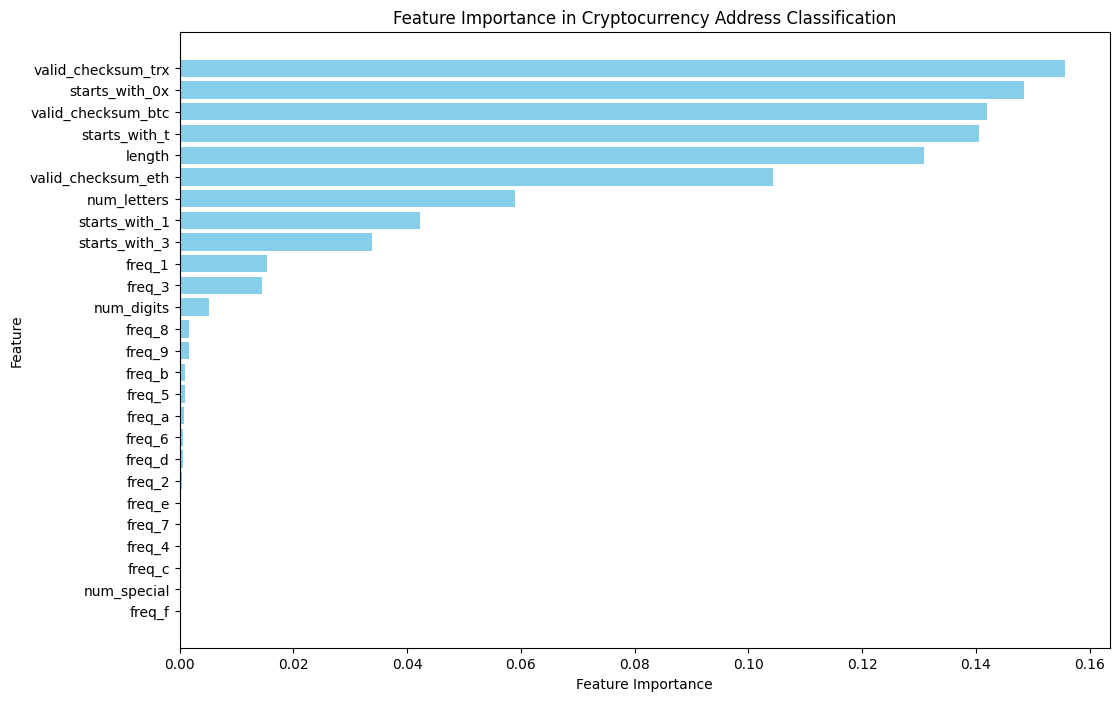

In [14]:
# Plot the feature importance
plt.figure(figsize=(12, 8))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Feature Importance in Cryptocurrency Address Classification')
plt.gca().invert_yaxis()
plt.show()

In [15]:
# Display the top 10 important features
print("Top 10 Important Features:")
print(importance_df.head(10))

Top 10 Important Features:
               Feature  Importance
25  valid_checksum_trx    0.155692
6       starts_with_0x    0.148399
23  valid_checksum_btc    0.141877
7        starts_with_t    0.140547
0               length    0.130835
24  valid_checksum_eth    0.104381
2          num_letters    0.058982
4        starts_with_1    0.042309
5        starts_with_3    0.033867
8               freq_1    0.015357


In [16]:
# Step 6: Model Deployment
# Save the model
joblib.dump(model, 'crypto_address_classifier.pkl')

['crypto_address_classifier.pkl']

In [17]:
# Function to classify a new cryptocurrency address
def classify_address(address):
    """
    Classifies a given cryptocurrency address using the trained model.
    
    Args:
    address (str): The cryptocurrency address to classify.
    
    Returns:
    str: The predicted type of the cryptocurrency address.
    """
    model = joblib.load('crypto_address_classifier.pkl')
    features = extract_features(address.lower())
    features_df = pd.DataFrame([features])
    prediction = model.predict(features_df)[0]
    return prediction
    

In [ ]:
# Main function to handle STDIN/STDOUT
def main():
    """
    Main function to read addresses from standard input and classify them.
    """
    print("Enter cryptocurrency addresses to classify (type 'exit' to quit):")
    while True:
        # Read from standard input
        address = input().strip()
        if address.lower() == 'exit':
            break
        # Classify the address
        try:
            result = classify_address(address)
            # Output the result to standard output
            print(f'The address {address} is classified as {result}')
        except Exception as e:
            print(f"Error classifying address: {str(e)}")

if __name__ == "__main__":
    main()

Enter cryptocurrency addresses to classify (type 'exit' to quit):


 TJm72RWCxv53NTCC4eGUCRTqXP2C5NB4R9


The address TJm72RWCxv53NTCC4eGUCRTqXP2C5NB4R9 is classified as TRX
